In [1]:
from __future__ import print_function
import keras
from pickle import dump,load
import numpy as np
from matplotlib import cm
from skimage.transform import rotate
from PIL import ImageFilter
import PIL
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
from numpy import newaxis
from google.colab import drive

drive.mount('/content/drive')

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28
desiredRows,desiredCols = 32,32

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, desiredRows, desiredCols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols)
    input_shape = (desiredRows, desiredRows, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#pad with 0s
print(x_train.shape)
x_train = np.pad(x_train,((0,0),(2,2),(2,2)),'constant')
x_test = np.pad(x_test,((0,0),(2,2),(2,2)),'constant')

x_train = x_train[:,:,:,newaxis]
x_test = x_test[:,:,:,newaxis]

n_test = x_test.shape[0]

#Data rotation
rot_angles = np.array(range(-45,45,5))
x_test_rotated = np.zeros((n_test,desiredRows,desiredCols,1,rot_angles.shape[0]))

imgInd = 0
angInd = 0
for ang in rot_angles:
  for img in x_test:
    x_test_rotated[imgInd,:,:,:,angInd] = rotate(img,ang)
    imgInd += 1
  angInd += 1
  imgInd = 0

#Data blurring
blur_radii = np.array(range(0,7,1))
x_test_blurred = np.zeros((n_test,desiredRows,desiredCols,1,blur_radii.shape[0]))

imgInd = 0
blurInd = 0
for rad in blur_radii:
  for img in x_test:
    im = PIL.Image.fromarray(np.uint8(np.reshape(img,[32,32])*255))
    im2 = im.filter(ImageFilter.GaussianBlur(rad))
    im3 = np.asarray(im2,dtype=float)/255.0
    
    x_test_blurred[imgInd,:,:,:,blurInd] = np.reshape(im3,[32,32,1])
    
    imgInd += 1
  blurInd += 1
  imgInd = 0

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
(60000, 28, 28)


array([0, 1, 2, 3, 4, 5, 6])

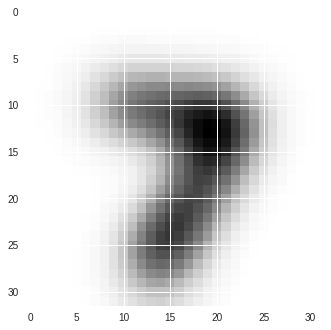

In [3]:
plt.imshow(np.reshape(x_test_blurred[0,:,:,:,3],[32,32]))
blur_radii

In [0]:
model = Sequential()

model.add(Conv2D(64,kernel_size=(3, 3),activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

model.add(Conv2D(256,kernel_size=(3, 3),padding='same',activation='relu',input_shape=input_shape))
model.add(Conv2D(256,kernel_size=(3, 3),padding='same',activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

model.add(Conv2D(512,kernel_size=(3, 3),padding='same',activation='relu',input_shape=input_shape))
model.add(Conv2D(512,kernel_size=(3, 3),padding='same',activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

model.add(Conv2D(512,kernel_size=(3, 3),padding='same',activation='relu',input_shape=input_shape))
model.add(Conv2D(512,kernel_size=(3, 3),padding='same',activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))



In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 256)         0         
__________

In [6]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

progress = model.fit(x_train, y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=(x_test,y_test),
                     verbose=1)

model.save("drive/My Drive/CS484_Assignment_3/CS484_model_3_1a")
with open('drive/My Drive/CS484_Assignment_3/CS484_history_3_1a', 'wb') as handle: 
    dump(progress, handle)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 65s 1ms/step - loss: 1.7241 - acc: 0.3495 - val_loss: 0.1796 - val_acc: 0.9505
Epoch 2/12
60000/60000 [==============================] - 59s 980us/step - loss: 0.1129 - acc: 0.9692 - val_loss: 0.0588 - val_acc: 0.9843
Epoch 3/12
60000/60000 [==============================] - 59s 981us/step - loss: 0.0498 - acc: 0.9861 - val_loss: 0.0421 - val_acc: 0.9888
Epoch 4/12
60000/60000 [==============================] - 59s 981us/step - loss: 0.0344 - acc: 0.9906 - val_loss: 0.0347 - val_acc: 0.9901
Epoch 5/12
60000/60000 [==============================] - 59s 981us/step - loss: 0.0233 - acc: 0.9937 - val_loss: 0.0300 - val_acc: 0.9921
Epoch 6/12
60000/60000 [==============================] - 59s 982us/step - loss: 0.0184 - acc: 0.9947 - val_loss: 0.0284 - val_acc: 0.9925
Epoch 7/12
60000/60000 [==============================] - 59s 984us/step - loss: 0.0130 - acc: 0.9962 - val_loss: 0.02

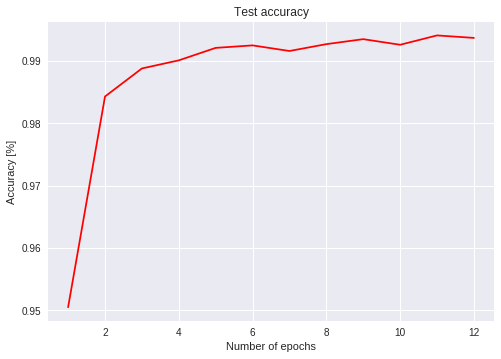

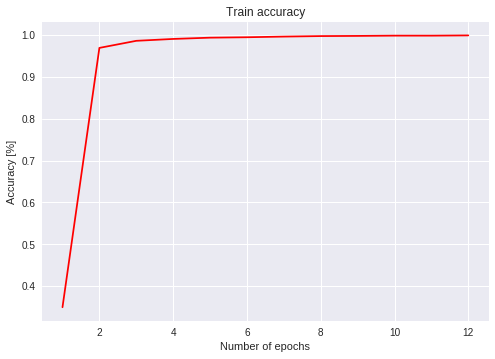

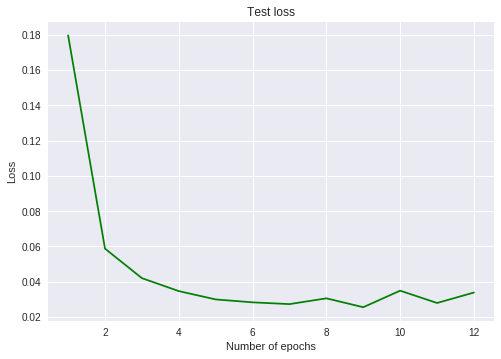

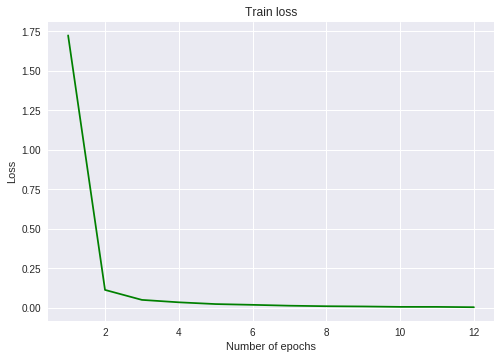

In [7]:
import matplotlib.pyplot as plt

#load model and history
model = keras.models.load_model("drive/My Drive/CS484_Assignment_3/CS484_model_3_1a")
with open('drive/My Drive/CS484_Assignment_3/CS484_history_3_1a', 'rb') as handle: # loading old history 
    progress = load(handle)

acc = progress.history['acc']
test_acc = progress.history['val_acc']
loss = progress.history['loss']
test_loss = progress.history['val_loss']

plt.figure()
epochs = range(1, len(acc) + 1)
plt.plot(epochs, test_acc, '-r', label='Test acc')
plt.title('Test accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy [%]')

plt.figure()
plt.plot(epochs, acc, '-r', label='Train acc')
plt.title('Train accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy [%]')

plt.figure()
plt.plot(epochs, test_loss, '-g', label='Test loss')
plt.title('Test loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochs, loss, '-g', label='Train loss')
plt.title('Train loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')

plt.show()

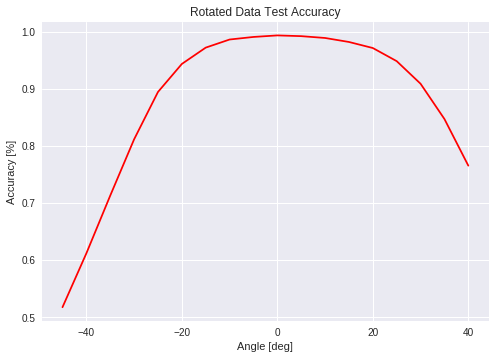

In [8]:
rot_test_acc = np.array([model.test_on_batch(x_test_rotated[:,:,:,:,i],y_test) for i in range(0,rot_angles.shape[0])])[:,1]

plt.figure()
plt.plot(rot_angles, rot_test_acc, '-r', label='rot test acc')
plt.title('Rotated Data Test Accuracy')
plt.xlabel('Angle [deg]')
plt.ylabel('Accuracy [%]')

plt.show()

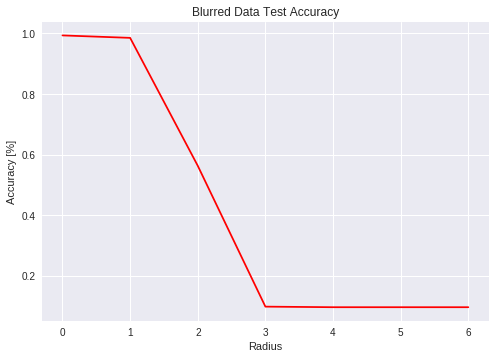

In [9]:
blur_test_acc = np.array([model.test_on_batch(x_test_blurred[:,:,:,:,i],y_test) for i in range(0,blur_radii.shape[0])])[:,1]

plt.figure()
plt.plot(blur_radii, blur_test_acc, '-r', label='blur test acc')
plt.title('Blurred Data Test Accuracy')
plt.xlabel('Radius')
plt.ylabel('Accuracy [%]')

plt.show()